# Gravity Spy Machine Learning Classifications of LIGO Glitches from Observing Runs O1, O2, O3a, and O3b

这个数据集名为"Gravity Spy Machine Learning Classifications of LIGO Glitches from Observing Runs O1, O2, O3a, and O3b"，由Glanzer等人在2021年发布(https://zenodo.org/record/5649212) 。数据集包含了LIGO观测运行O1, O2, O3a和O3b期间，Gravity Spy机器学习模型对LIGO故障的所有分类。

我们将专注于 `H1_O1.csv` 和 `L1_O1.csv` 这两个数据文件。这些文件包含了LIGO的H1和L1探测器在O1观测运行期间的数据。每个文件都包含了多个字段，包括事件时间、峰值时间、开始时间、持续时间、峰值频率、中心频率、带宽、信道、振幅、信噪比、Q值等，这些都是Omicron流水线提供的信号元数据。此外，还有机器学习对每个 glitch 的预测标签和分类置信度，以及指向公开可用的 [Omega scan](https://en.wikipedia.org/wiki/Constant-Q_transform) 的链接。

[Omega scan](https://en.wikipedia.org/wiki/Constant-Q_transform) 是一种 Q-transform 时频图，可以帮助我们理解噪声和事件信号的形态。在我们的教程中，我们将使用这些链接下载时频图，并基于这些图像信息来训练聚类模型。

- The data set is described in [Glanzer et al. (2023)](https://doi.org/10.1088/1361-6382/acb633), which we ask to be cited in any publications using this data release. Example code using the data can be found in this [Colab notebook](https://colab.research.google.com/drive/19q_lItODPk7qw_sohlHyWPnAbY0FZyt8?usp=sharing#scrollTo=KJu83v4LkTZK).


<details>
  <summary>点击折叠/展开</summary>

![](https://cdn.sa.net/2023/12/24/9ebZ8FU2VgsaKTE.jpg)
>... The symbols indicate the different known glitch classes, as well as subjects that fall in the None of the Above category. This view shows the clustering along two of many possible dimensions. The Gravity Spy team is building tools that use the results of these clustering analyses to support volunteers in identifying new glitch classes. ...
>
>FROM: Trouille L, Lintott C J, Fortson L F. Citizen science frontiers: Efficiency, engagement, and serendipitous discovery with human–machine systems[J]. Proceedings of the National Academy of Sciences, 2019, 116(6): 1902-1909.
  
</details>

# Load libs and meta data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import requests
from PIL import Image # pip install Pillow
from io import BytesIO
from concurrent.futures import ThreadPoolExecutor
import os

In [2]:
df = pd.concat([
    pd.read_csv('data/H1_O1.csv'),
    pd.read_csv('data/L1_O1.csv')
])
df = df[df['ml_confidence'] >= 0.95]
df = df[df['duration'] <= 0.5]
df = df[df.url1 != '?']
df = df.reset_index().drop('index', axis=1)

assert np.alltrue(((df.url1 != '?') & (df.url2 != '?') & (df.url3 != '?') & (df.url4 != '?')).values)
df

,event_time,ifo,peak_time,peak_time_ns,start_time,start_time_ns,duration,peak_frequency,central_freq,bandwidth,...,Tomte,Violin_Mode,Wandering_Line,Whistle,ml_label,ml_confidence,url1,url2,url3,url4
0,1.133139e+09,H1,1133138521,980957031,1133138521,937500000,0.12500,262.064606,1576.186646,3022.359619,...,3.072279e-09,2.971510e-08,8.763691e-08,3.973809e-05,Blip,0.999553,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
1,1.133107e+09,H1,1133106912,958983898,1133106912,937500000,0.12500,89.676369,201.923874,319.184143,...,1.479493e-07,5.060389e-07,3.929701e-07,8.703923e-06,Blip,0.998819,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
2,1.132793e+09,H1,1132793065,102539062,1132793065,93750000,0.06250,137.711487,157.986481,154.858337,...,3.074078e-06,1.106673e-06,1.806507e-07,1.722847e-04,Blip,0.991125,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
3,1.132482e+09,H1,1132481586,469726085,1132481586,453125000,0.03125,111.128151,303.809998,502.703705,...,2.823870e-08,6.811245e-08,1.238232e-07,3.101678e-06,Blip,0.999100,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
4,1.134276e+09,H1,1134276055,409178972,1134276055,390625000,0.04688,137.711487,201.923874,319.184143,...,1.647925e-07,8.733855e-08,1.018298e-07,1.490301e-06,Blip,0.997329,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6028,1.134631e+09,L1,1134630964,500731945,1134630964,468750000,0.12500,498.708282,1031.460449,1958.004639,...,7.822239e-08,1.465113e-07,1.878047e-07,5.879506e-05,Blip,0.998476,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
6029,1.128404e+09,L1,1128404075,285156011,1128404075,257812023,0.05469,120.558327,194.108719,157.183563,...,2.106966e-09,1.539225e-08,1.787887e-08,1.134432e-08,Helix,0.999063,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
6030,1.130201e+09,L1,1130201058,187500000,1130201057,875000000,0.50000,65.531433,118.496696,108.992218,...,3.851338e-09,1.653250e-08,3.102663e-09,8.317840e-08,Power_Line,0.999924,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
6031,1.137220e+09,L1,1137219636,326172113,1137219636,250000000,0.10547,1527.022095,1802.779419,1581.367554,...,4.835338e-12,2.648552e-08,9.646576e-10,7.214756e-04,1400Ripples,0.999278,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...


In [3]:
df.ml_label.value_counts()

ml_label
Blip                   2523
1400Ripples            1132
Scratchy                531
Power_Line              366
Repeating_Blips         248
Helix                   239
No_Glitch               194
Whistle                 158
Light_Modulation        146
Low_Frequency_Burst     112
Violin_Mode             112
Air_Compressor           73
Paired_Doves             70
Chirp                    53
Low_Frequency_Lines      19
Tomte                    16
Koi_Fish                 13
Scattered_Light          11
Wandering_Line           10
Extremely_Loud            5
1080Lines                 1
None_of_the_Above         1
Name: count, dtype: int64

In [4]:
target_labels = [label
                 for label in df.ml_label.value_counts()[df.ml_label.value_counts() > 100].index
                 if label not in ['No_Glitch', '1400Ripples']]
df_selected = pd.concat([df[df.ml_label == label].sample(100)
                         for label in target_labels])
df_selected.shape

(900, 43)

In [5]:
df_selected.ml_label.value_counts()

ml_label
Blip                   100
Scratchy               100
Power_Line             100
Repeating_Blips        100
Helix                  100
Whistle                100
Light_Modulation       100
Low_Frequency_Burst    100
Violin_Mode            100
Name: count, dtype: int64

[‘url1’, ‘url2’, ‘url3’, ‘url4’] are the links to the publicly-available Omega scans for each glitch. ‘url1’ shows the glitch for a duration of 0.5 seconds, ‘url2’ for 1 seconds, ‘url3’ for 2 seconds, and ‘url4’ for 4 seconds.

In [6]:
df_selected

,event_time,ifo,peak_time,peak_time_ns,start_time,start_time_ns,duration,peak_frequency,central_freq,bandwidth,...,Tomte,Violin_Mode,Wandering_Line,Whistle,ml_label,ml_confidence,url1,url2,url3,url4
2300,1.127987e+09,H1,1127986873,426757097,1127986873,312500000,0.31250,121.663269,207.973999,337.349854,...,2.804348e-04,8.221391e-06,3.744328e-06,2.074782e-04,Blip,0.971899,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
5073,1.129516e+09,L1,1129515889,590820074,1129515889,562500000,0.06250,149.414139,665.750061,1252.902100,...,9.116752e-07,5.333438e-07,4.547436e-07,1.566210e-05,Blip,0.998085,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
2629,1.132308e+09,H1,1132308074,239257097,1132308074,234375000,0.01562,137.711487,256.501099,382.988556,...,6.472972e-07,5.988134e-06,2.234604e-06,9.918171e-05,Blip,0.997217,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
1818,1.135866e+09,H1,1135865774,753417968,1135865774,687500000,0.25000,262.064606,440.050079,824.968018,...,5.007841e-07,9.803334e-07,8.893833e-07,6.615333e-05,Blip,0.997145,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
5075,1.127608e+09,L1,1127607833,642088890,1127607833,576172113,0.07227,225.349274,432.315521,645.060852,...,2.439942e-06,3.965280e-06,2.885218e-06,5.096323e-03,Blip,0.955842,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,1.129802e+09,H1,1129802156,952147960,1129802156,921875000,0.10938,2025.310181,1838.466431,3612.932861,...,6.695334e-12,9.898326e-01,7.149766e-04,1.730928e-07,Violin_Mode,0.989833,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
363,1.129802e+09,H1,1129802368,389647960,1129802368,374022960,0.10254,2025.310181,2010.790894,3268.283936,...,5.993836e-13,9.999763e-01,2.001305e-05,2.968794e-06,Violin_Mode,0.999976,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
2015,1.129802e+09,H1,1129801533,235351085,1129801533,178221940,0.13428,2025.310181,1972.764160,3881.528320,...,2.009019e-10,9.999322e-01,4.737839e-07,3.143025e-05,Violin_Mode,0.999932,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
2601,1.129802e+09,H1,1129802346,715820074,1129802346,648437023,0.08594,2025.310181,2084.469482,2380.697266,...,1.626018e-10,9.987896e-01,1.088152e-03,1.401125e-06,Violin_Mode,0.998790,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...


# A case

In [8]:
url

'https://panoptes-uploads.zooniverse.org/production/subject_location/b51852bc-dc6d-47a3-83ef-98f7bdbb0064.png'

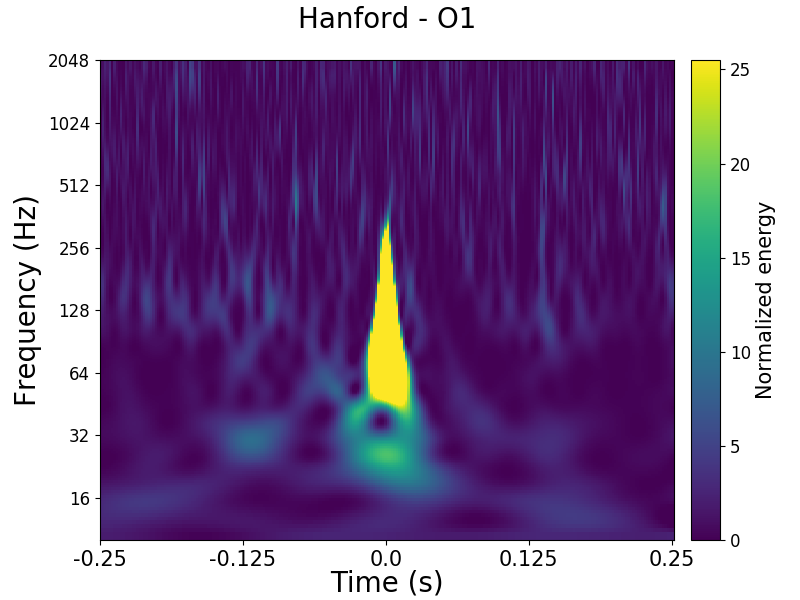

(600, 800, 4)

In [7]:
url = df_selected.url1.iloc[0]
response = requests.get(url)
with Image.open(BytesIO(response.content)) as img:
    img.show()
    data_img = np.array(img)
data_img.shape

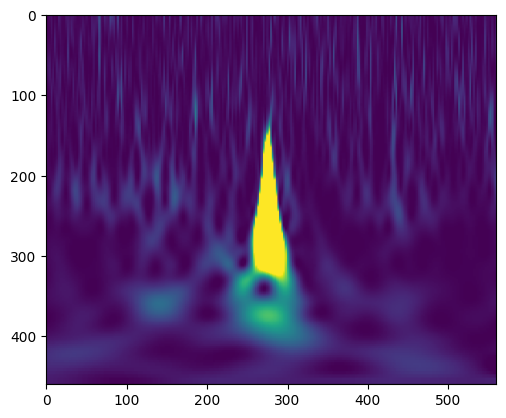

(460, 560, 4)

In [9]:
# 将numpy数组转换回图片并显示
img_from_array = Image.fromarray(data_img[80:540,110:670])
plt.imshow(img_from_array)
plt.show()

data_img[80:540,110:670].shape

- png图片是4通道 RGBA图像,具有4个通道(红色、绿色、蓝色和透明度),用于表示彩色图像以及透明度信息。
- `.convert("RGB")` 转换为三原色通道

100%|██████████| 9/9 [00:52<00:00,  5.89s/it]


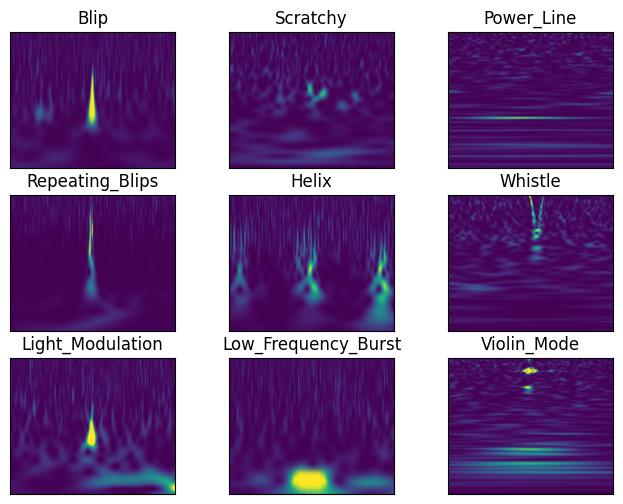

In [13]:
# 将numpy数组转换回图片并显示
plt.figure(figsize=(8,6))
assert len(target_labels) == 9
for i, label in enumerate(tqdm(target_labels)):
    url = df_selected[df_selected.ml_label == label].sample(1).url1.iloc[0]
    response = requests.get(url)
    with Image.open(BytesIO(response.content)) as img:
        data_img = np.array(img.convert("RGB"))
    plt.subplot(3,3,i+1)
    img_from_array = Image.fromarray(data_img[80:540,110:670])
    plt.imshow(img_from_array)
    plt.xticks([])
    plt.yticks([])
    plt.title(label)
plt.show()

# Load all pngs

In [14]:
num_cores = os.cpu_count()
print(num_cores)

def load_url_data(url):
    response = requests.get(url)
    try:
        with Image.open(BytesIO(response.content)) as img:
            data = np.array(img.convert("RGB"))[80:540,110:670]
    except:
        data = np.zeros((460, 560, 4))
    return data

def load_data(url):
    data = load_url_data(url)
    return data[np.newaxis, ...]

96


In [15]:
urls = df_selected.url1.values.tolist()

with ThreadPoolExecutor(max_workers=num_cores-5) as executor:
    results = list(tqdm(executor.map(load_data, urls), total=len(urls)))

data = np.concatenate(results)
data.shape

100%|██████████| 900/900 [01:05<00:00, 13.64it/s]


(900, 460, 560, 3)

# Model: TSNE

<details>
  <summary>点击折叠/展开</summary>
  
![](https://cdn.sa.net/2023/12/24/VCHPOogc2sNBRE5.jpg)
  
</details>


t-SNE（t-Distributed Stochastic Neighbor Embedding）是一种用于高维数据可视化的工具，由van der Maaten和Hinton在2008年提出。

t-SNE的目标是在低维空间（通常是2D平面）中找到高维数据的一种忠实表示。这种算法是非线性的，并且会根据数据的不同区域进行不同的转换。

t-SNE的主要特点和适用范围如下：

1. 灵活性：t-SNE可以找到其他降维算法无法发现的结构，这使得它在探索高维数据时非常有用。

2. 局部和全局结构：t-SNE有一个可调参数“perplexity”，它决定了算法在考虑数据的局部和全局结构时的平衡。在某种意义上，这个参数是对每个点的近邻数量的猜测。

3. 随机性：t-SNE算法在不同的运行中可能会产生不同的输出，这是因为它使用了随机过程。

4. 可视化：t-SNE最常用于高维数据的可视化，它可以生成吸引人的二维“地图”。

然而，t-SNE也有一些需要注意的地方：(Ref: https://distill.pub/2016/misread-tsne/)

1. 解释性：由于t-SNE的非线性和适应性，它的结果有时可能难以解释。例如，t-SNE图中的簇的大小或者空间距离并不总是反映原始数据的结构。

2. 超参数调整：t-SNE有一些需要调整的超参数，如“perplexity”和学习率。这些参数的选择可能会对结果产生显著影响。

3. 计算复杂性：t-SNE的计算复杂性较高，对于大规模数据集，可能需要较长的计算时间。

总的来说，t-SNE是一种强大的工具，但使用时需要理解其工作原理和限制，以正确地解释和利用其结果。



In [16]:
data_grey = data.mean(axis=3) # 灰度图
data_grey.shape

(900, 460, 560)

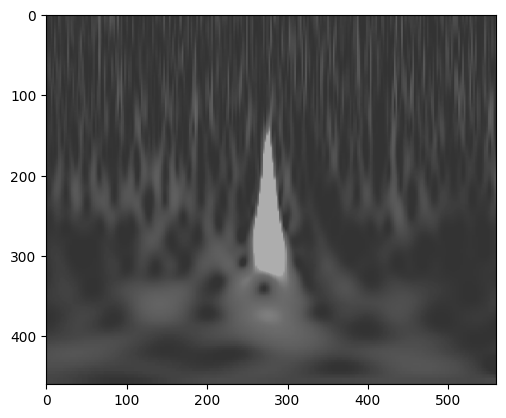

In [17]:
# 将numpy数组转换回图片并显示
img_from_array = Image.fromarray(data_grey[0])
plt.imshow(img_from_array)
plt.show()

In [18]:
# 将数据转换为2维
data_2d = data_grey.reshape(data.shape[0], -1)
print(data_2d.shape)

(900, 257600)


In [23]:
%%time
from sklearn.manifold import TSNE

# 使用TSNE进行降维
tsne = TSNE(n_components=2, perplexity=50.0, n_iter=5000)
data_tsne = tsne.fit_transform(data_2d)
data_tsne.shape

CPU times: user 4min 44s, sys: 1min 1s, total: 5min 46s
Wall time: 11 s


(900, 2)

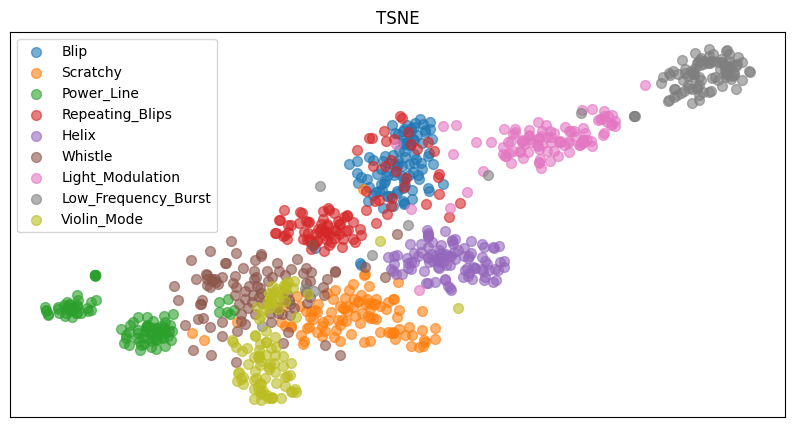

In [24]:
step = 100
# 绘制TSNE的结果
plt.figure(figsize=(10, 5))
for i in range(len(data_2d) // step):
    plt.scatter(data_tsne[i*step:i*step+step, 0], data_tsne[i*step:i*step+step, 1], s=50, label=target_labels[i], alpha=0.6)
plt.legend()
plt.xticks([])
plt.yticks([])
plt.title('TSNE');

# Model: UMAP

<details>
  <summary>点击折叠/展开</summary>
  
![](https://cdn.sa.net/2023/12/24/pUGZ3lok8TEH9CR.jpg)
>https://meta.caspershire.net/umap/
</details>


UMAP（Uniform Manifold Approximation and Projection）是一种用于降维的算法，由McInnes等人在2018年提出。UMAP的目标是在低维空间中找到高维数据的一种忠实表示，同时保留数据的全局结构和局部结构。

> https://umap-learn.readthedocs.io/en/latest/

UMAP的主要特点和适用范围如下：

1. 灵活性：UMAP可以处理各种类型的数据，包括数值数据、分类数据、文本数据等。这使得UMAP在许多不同的应用中都非常有用。

2. 速度：UMAP的运行速度比许多其他降维算法更快，这使得它可以处理大规模的数据集。

3. 保留全局结构：与t-SNE不同，UMAP不仅保留了数据的局部结构，还保留了数据的全局结构。这意味着在UMAP的结果中，距离和密度都有意义。

4. 可扩展性：UMAP可以用于超过2或3维的降维，这使得它可以用于各种需要降维的任务。

然而，UMAP也有一些需要注意的地方：

1. 解释性：由于UMAP的复杂性，它的结果有时可能难以解释。例如，UMAP图中的簇的大小或者空间距离并不总是反映原始数据的结构。

2. 超参数调整：UMAP有一些需要调整的超参数，如n_neighbors和min_dist。这些参数的选择可能会对结果产生显著影响。

总的来说，UMAP是一种强大的降维工具，但使用时需要理解其工作原理和限制，以正确地解释和利用其结果。

In [21]:
%%time
# !pip install umap-learn
from umap import UMAP

# 使用UMAP进行降维
reducer = UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
data_umap = reducer.fit_transform(data_2d)
data_umap.shape

/root/miniconda3/envs/ictp_ap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CPU times: user 7min 51s, sys: 7.45 s, total: 7min 59s
Wall time: 1min 24s


(900, 2)

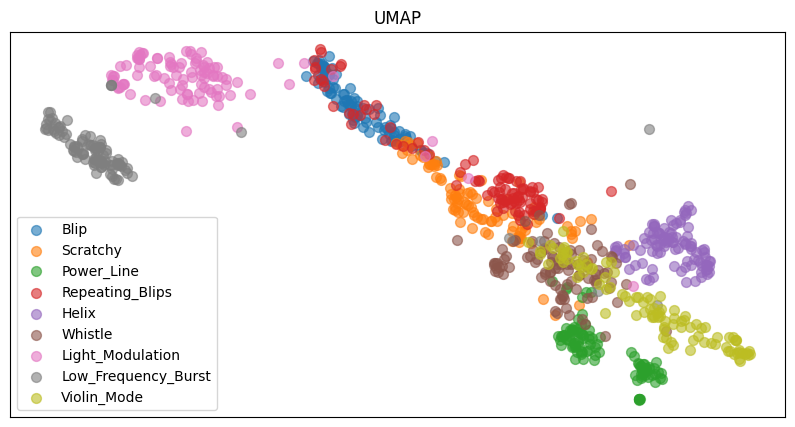

In [22]:
step = 100
# 绘制UMAP的结果
plt.figure(figsize=(10, 5))
for i in range(len(data_2d) // step):
    plt.scatter(data_umap[i*step:i*step+step, 0], data_tsne[i*step:i*step+step, 1], s=50, label=target_labels[i], alpha=0.6)
plt.legend()
plt.xticks([])
plt.yticks([])
plt.title('UMAP');